In [1]:
import json
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import mplhep as mh

from hist.hist import Hist
from hist.axis import Regular

In [2]:
mh.style.use(mh.styles.CMS)

In [139]:
year = 2022

input_path = f'/store/scratch/seyang/rpc/tnp-nanoaod/Run{year}.root'
geom_path = '../data/rpc-geometry.csv'
roll_blacklist_path = '../data/roll-blacklist.json'

In [140]:
h_total = uproot.open(f'{input_path}:total').to_hist()
h_passed = uproot.open(f'{input_path}:passed').to_hist()

In [141]:
total = h_total.values()
passed = h_passed.values()

eff = np.divide(passed, total, out=np.zeros_like(total), where=(total > 0))

In [142]:
# geometry information
geom = pd.read_csv(geom_path)

In [143]:
barrel_roll_arr = geom.roll_name[geom.region == 0].to_numpy()

In [144]:
with open(roll_blacklist_path) as stream:
    roll_blacklist = set(json.load(stream))

In [145]:
roll_axis = h_total.axes[0]

In [146]:
roll_name_list = [roll_axis.value(idx) for idx in range(roll_axis.size)]

In [147]:
is_barrel = np.vectorize(lambda item: item.startswith('W'))
is_allowed = np.vectorize(lambda item: item not in roll_blacklist)

barrel_mask = is_barrel(roll_name_list)
endcap_mask = np.logical_not(barrel_mask)

whitelist_mask = is_allowed(roll_name_list)

barrel_mask &= whitelist_mask
endcap_mask &= whitelist_mask

mask_dict = {
    'barrel': barrel_mask,
    'endcap': endcap_mask
}

In [148]:
where = 'barrel'
mask = mask_dict[where]
masked_eff = 100 * eff[mask]

entries = mask.sum()
mean = masked_eff.mean()
rms = masked_eff.std()
underflow = (masked_eff < 70).sum()

eff_axis = Regular(1010, 0, 101)
h_eff = Hist(eff_axis)
h_eff.fill(masked_eff)

Hist(Regular(1010, 0, 101, label='Axis 0'), storage=Double()) # Sum: 1020.0

In [149]:
color_dict = {
    'barrel': {
        'facecolor': '#84c1a3',
        'edgecolor': "#007700",
    },
    'endcap': {
        'facecolor': '#7c99d1',
        'edgecolor': '#000099',
    }
}

In [150]:
def plot(where, year):
    mask = mask_dict[where]
    masked_eff = 100 * eff[mask]

    entries = mask.sum()
    mean = masked_eff.mean()
    rms = masked_eff.std()
    underflow = (masked_eff < 70).sum()
    
    mean_70 = masked_eff[masked_eff > 70].mean()

    eff_axis = Regular(1010, 0, 101)
    h_eff = Hist(eff_axis)
    h_eff.fill(masked_eff)


    facecolor = color_dict[where]['facecolor']
    edgecolor = color_dict[where]['edgecolor']

    fig, ax = plt.subplots()
    h_eff[70j::10j].plot(ax=ax, yerr=False, histtype='fill', facecolor=facecolor, edgecolor=edgecolor, linewidth=2, flow='none')

    ax.set_xlabel('Efficiency [%]')
    ax.set_ylabel('Number of Rolls')
    ax.set_xlim(70, 100)

    x0 = 0.1
    x1 = 0.6
    
    y0 = 0.9
    dy = 0.06
    y1 = y0 - dy
    y2 = y0 - 2*dy
    y3 = y0 - 3*dy
    y4 = y0 - 4.5*dy
    
    ax.annotate(f'Entries', xy=(x0, y0), xycoords='axes fraction')
    ax.annotate(f'{entries:d}', xy=(x1, y0), xycoords='axes fraction', ha='right')
    
    
    ax.annotate(f'Mean', xy=(x0, y1), xycoords='axes fraction')
    ax.annotate(f'{mean:.2f}', xy=(x1, y1), xycoords='axes fraction', ha='right')
    
    
    ax.annotate(f'RMS', xy=(x0, y2), xycoords='axes fraction')
    ax.annotate(f'{rms:.2f}', xy=(x1, y2), xycoords='axes fraction', ha='right')
    
    ax.annotate(f'Underflow', xy=(x0, y3), xycoords='axes fraction')
    ax.annotate(f'{underflow:d}', xy=(x1, y3), xycoords='axes fraction', ha='right')
    
    ax.annotate(rf'Mean ($\epsilon$>70%)', xy=(x0, y4), xycoords='axes fraction')
    ax.annotate(f'{mean_70:.2f}', xy=(x1, y4), xycoords='axes fraction', ha='right')
    
    
    #mh.cms.label(ax=ax, loc=1, llabel='', rlabel='', year=False, com=False)

    #mh.cms.label(ax=ax, llabel=f'RPC Efficiency - {where.title()}', com=13.6, year='2023', exp='')
    mh.cms.label(ax=ax, llabel=f'Preliminary', com=13.6, year=year)
    
    fig.savefig(f'./output/{where}-{year}.pdf')
    return fig

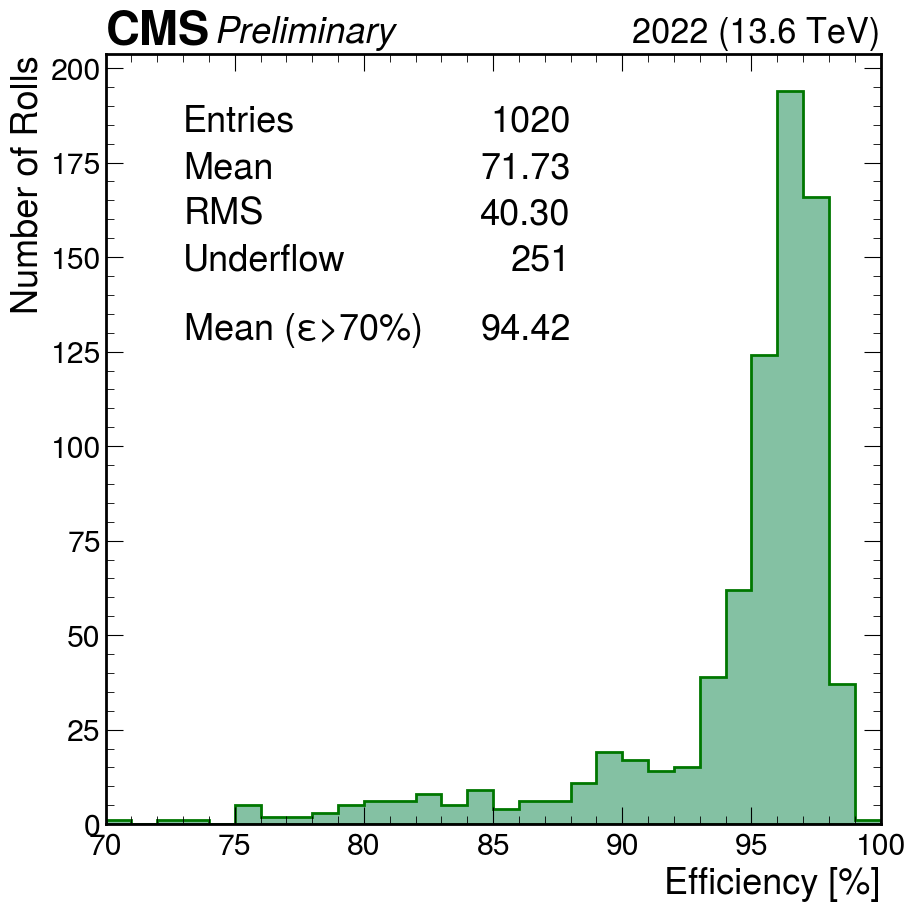

In [151]:
fig = plot('barrel', year=year)

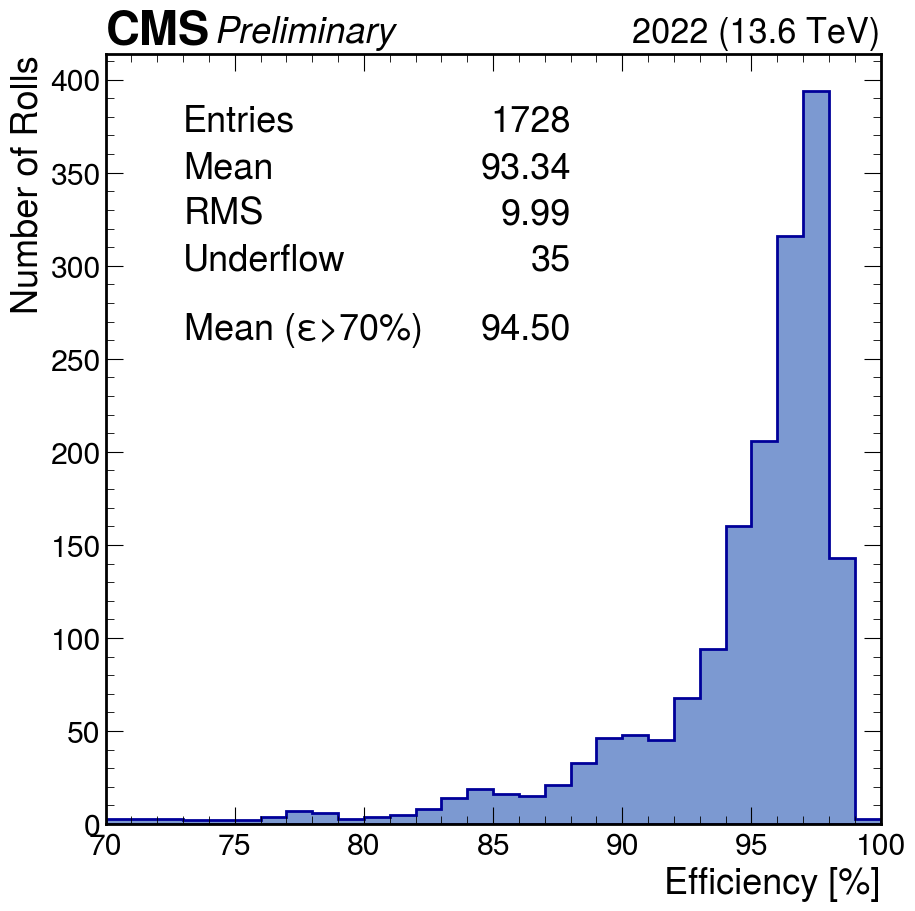

In [152]:
fig = plot('endcap', year=year)